## ***INTRO***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install Wordcloud
!pip install Sastrawi
!pip install nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import pickle
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.naive_bayes import MultinomialNB

from wordcloud import WordCloud, STOPWORDS

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PDM/new_scrapped_data.csv')
data.head()

,score,content
0,5,"Guah pelanggan GRAB dari pertama ada GRAB,,, d..."
1,4,Dapat dibilang saya sangat bergantung pada Gra...
2,3,Titik suka tidak sesuai padahal sudah saya ses...
3,5,Aplikasinya bagus dan tampilan antarmukanya ju...
4,5,Driver ojek online merupakan bagian integral d...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   score    2000 non-null   int64 
 1   content  2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
data.describe()

,score
count,2000.00000
mean,2.83600
std,1.76654
min,1.00000
25%,1.00000
50%,2.00000
75%,5.00000
max,5.00000


In [ ]:
data.describe()

,score
count,2000.00000
mean,2.83600
std,1.76654
min,1.00000
25%,1.00000
50%,2.00000
75%,5.00000
max,5.00000


***Labeling***

In [ ]:
# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Fungsi untuk memberi label berdasarkan skor
def label_sentiment(score):
    return 'positif' if score > 3 else 'negatif'

# Menambah kolom label ke DataFrame
df['label'] = df['score'].apply(label_sentiment)

# Menampilkan DataFrame yang sudah diberi label
df.head(10)

,score,content,label
0,5,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",positif
1,4,Dapat dibilang saya sangat bergantung pada Gra...,positif
2,3,Titik suka tidak sesuai padahal sudah saya ses...,negatif
3,5,Aplikasinya bagus dan tampilan antarmukanya ju...,positif
4,5,Driver ojek online merupakan bagian integral d...,positif
5,3,Tolong perbaiki pembayaran Qris. Sering eror. ...,negatif
6,1,"Tolong maps-nya di update, biar titiknya makin...",negatif
7,1,"Aplikasi terburuk menurut saya, buat ambil pro...",negatif
8,3,Tolong perbaiki grabfoodnya apalagi yang ingin...,negatif
9,1,Maps nya yg bener aja dong Maps nya gak update...,negatif


In [ ]:
print(df['label'].value_counts())

label
negatif    1180
positif     820
Name: count, dtype: int64


## **Case Folding & Text Cleaning**

In [ ]:
# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Fungsi untuk melakukan case folding dan text cleaning
def clean_text(text):
    text = text.lower()  # Case folding: membuat semua huruf menjadi huruf kecil
    text = re.sub(r'[^a-z\s]', '', text)  # Menghapus semua karakter kecuali huruf dan spasi
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih dan spasi di awal/akhir
    return text

# Menerapkan fungsi clean_text pada kolom 'content'
df['cleaned_content'] = df['content'].apply(clean_text)

df['label'] = df['score'].apply(label_sentiment)
df.head(10)

,score,content,cleaned_content,label
0,5,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",guah pelanggan grab dari pertama ada grab dan ...,positif
1,4,Dapat dibilang saya sangat bergantung pada Gra...,dapat dibilang saya sangat bergantung pada gra...,positif
2,3,Titik suka tidak sesuai padahal sudah saya ses...,titik suka tidak sesuai padahal sudah saya ses...,negatif
3,5,Aplikasinya bagus dan tampilan antarmukanya ju...,aplikasinya bagus dan tampilan antarmukanya ju...,positif
4,5,Driver ojek online merupakan bagian integral d...,driver ojek online merupakan bagian integral d...,positif
5,3,Tolong perbaiki pembayaran Qris. Sering eror. ...,tolong perbaiki pembayaran qris sering eror da...,negatif
6,1,"Tolong maps-nya di update, biar titiknya makin...",tolong mapsnya di update biar titiknya makin l...,negatif
7,1,"Aplikasi terburuk menurut saya, buat ambil pro...",aplikasi terburuk menurut saya buat ambil prom...,negatif
8,3,Tolong perbaiki grabfoodnya apalagi yang ingin...,tolong perbaiki grabfoodnya apalagi yang ingin...,negatif
9,1,Maps nya yg bener aja dong Maps nya gak update...,maps nya yg bener aja dong maps nya gak update...,negatif


## **Tokenized**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
#Tokenizing
tokenized = df['cleaned_content'].apply(lambda x:x.split())
tokenized

0       [guah, pelanggan, grab, dari, pertama, ada, gr...
1       [dapat, dibilang, saya, sangat, bergantung, pa...
2       [titik, suka, tidak, sesuai, padahal, sudah, s...
3       [aplikasinya, bagus, dan, tampilan, antarmukan...
4       [driver, ojek, online, merupakan, bagian, inte...
                              ...                        
1995    [pas, di, titik, pesanan, driver, nya, ramah, ...
1996    [aplikasi, yg, sangat, luar, biasa, membantu, ...
1997    [suka, sama, app, ini, karena, mempermudah, pe...
1998    [pada, awalnya, untuk, beberapa, saat, sy, san...
1999    [kenapa, sekarang, kalo, masuk, ke, grabfood, ...
Name: cleaned_content, Length: 2000, dtype: object

## **Stopwords Removal**

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load stopwords for Indonesian
stop = stopwords.words('indonesian')

# Apply stopwords removal using lambda function
df['content_StopWord'] = df['cleaned_content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop)]))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,score,content,cleaned_content,label,content_StopWord
0,5,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",guah pelanggan grab dari pertama ada grab dan ...,positif,guah pelanggan grab grab gua udh pakai apk zam...
1,4,Dapat dibilang saya sangat bergantung pada Gra...,dapat dibilang saya sangat bergantung pada gra...,positif,dibilang bergantung grab pesan makanan nitip b...
2,3,Titik suka tidak sesuai padahal sudah saya ses...,titik suka tidak sesuai padahal sudah saya ses...,negatif,titik suka sesuai sesuaikan titik biru terkada...
3,5,Aplikasinya bagus dan tampilan antarmukanya ju...,aplikasinya bagus dan tampilan antarmukanya ju...,positif,aplikasinya bagus tampilan antarmukanya bagus ...
4,5,Driver ojek online merupakan bagian integral d...,driver ojek online merupakan bagian integral d...,positif,driver ojek online integral layanan transporta...


## **Stemming Data**

In [ ]:
# Menerapkan fungsi clean_text pada kolom 'content'
df['cleaned_content'] = df['content'].apply(clean_text)

# Menggunakan Sastrawi untuk stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk stemming teks
def stem_text(text):
    return stemmer.stem(text)

# Menerapkan fungsi stem_text pada kolom 'content_StopWord'
df['stemmed_content'] = df['content_StopWord'].apply(stem_text)
df.head(10)

,score,content,cleaned_content,label,content_StopWord,stemmed_content
0,5,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",guah pelanggan grab dari pertama ada grab dan ...,positif,guah pelanggan grab grab gua udh pakai apk zam...,guah langgan grab grab gua udh pakai apk zaman...
1,4,Dapat dibilang saya sangat bergantung pada Gra...,dapat dibilang saya sangat bergantung pada gra...,positif,dibilang bergantung grab pesan makanan nitip b...,bilang gantung grab pesan makan nitip beli oba...
2,3,Titik suka tidak sesuai padahal sudah saya ses...,titik suka tidak sesuai padahal sudah saya ses...,negatif,titik suka sesuai sesuaikan titik biru terkada...,titik suka sesuai sesuai titik biru terkadang ...
3,5,Aplikasinya bagus dan tampilan antarmukanya ju...,aplikasinya bagus dan tampilan antarmukanya ju...,positif,aplikasinya bagus tampilan antarmukanya bagus ...,aplikasi bagus tampil antarmuka bagus kendala ...
4,5,Driver ojek online merupakan bagian integral d...,driver ojek online merupakan bagian integral d...,positif,driver ojek online integral layanan transporta...,driver ojek online integral layan transportasi...
5,3,Tolong perbaiki pembayaran Qris. Sering eror. ...,tolong perbaiki pembayaran qris sering eror da...,negatif,tolong perbaiki pembayaran qris eror tambahin ...,tolong baik bayar qris eror tambahin fitur gal...
6,1,"Tolong maps-nya di update, biar titiknya makin...",tolong mapsnya di update biar titiknya makin l...,negatif,tolong mapsnya update biar titiknya lengkap se...,tolong mapsnya update biar titik lengkap sesua...
7,1,"Aplikasi terburuk menurut saya, buat ambil pro...",aplikasi terburuk menurut saya buat ambil prom...,negatif,aplikasi terburuk ambil promo berteletele prom...,aplikasi buruk ambil promo berteletele promo t...
8,3,Tolong perbaiki grabfoodnya apalagi yang ingin...,tolong perbaiki grabfoodnya apalagi yang ingin...,negatif,tolong perbaiki grabfoodnya memesan malem oran...,tolong baik grabfoodnya mes malem orang makan ...
9,1,Maps nya yg bener aja dong Maps nya gak update...,maps nya yg bener aja dong maps nya gak update...,negatif,maps nya yg bener aja maps nya gak update gima...,maps nya yg bener aja maps nya gak update gima...


## ***Menyimpan Data Hasil Stemming***

In [ ]:
df.to_csv("Stemmed Pre-Processing Grab.csv.csv")

## ***DATA FOR TESTING***

***Word Cloud Positif***

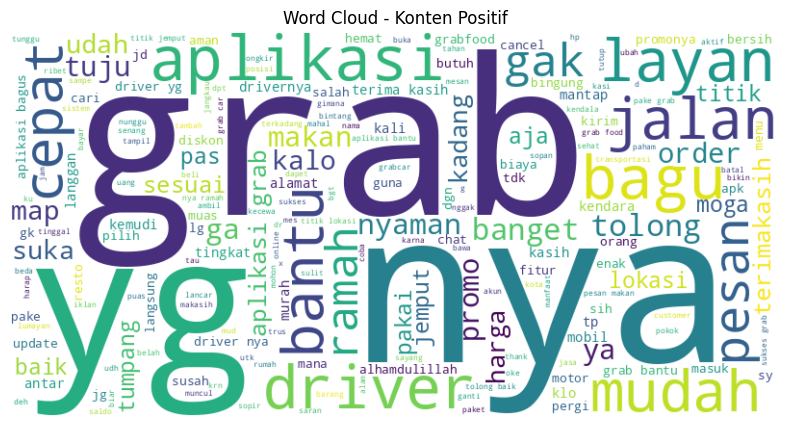

In [ ]:
# Membuat word cloud untuk konten positif
positive_text = ' '.join(df[df['label'] == 'positif']['stemmed_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Konten Positif')
plt.axis('off')
plt.show()

***Word Cloud Negatif***

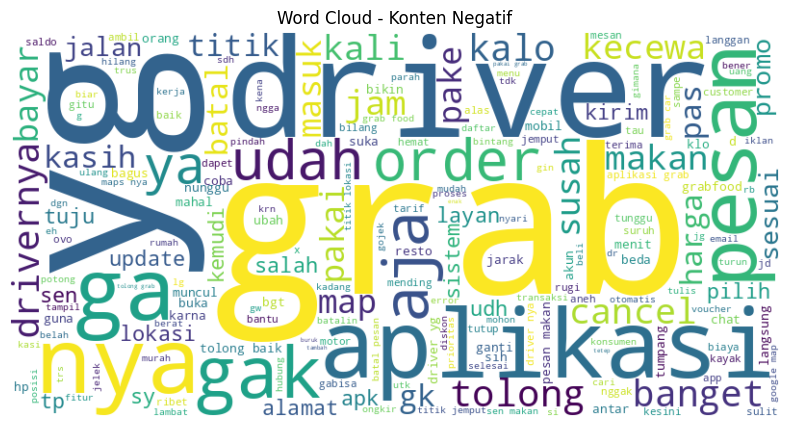

In [ ]:
# Membuat word cloud untuk konten negatif
positive_text = ' '.join(df[df['label'] == 'negatif']['stemmed_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Konten Negatif')
plt.axis('off')
plt.show()

***Distribusi Label***

<ipython-input-73-e8a53105b84e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel')


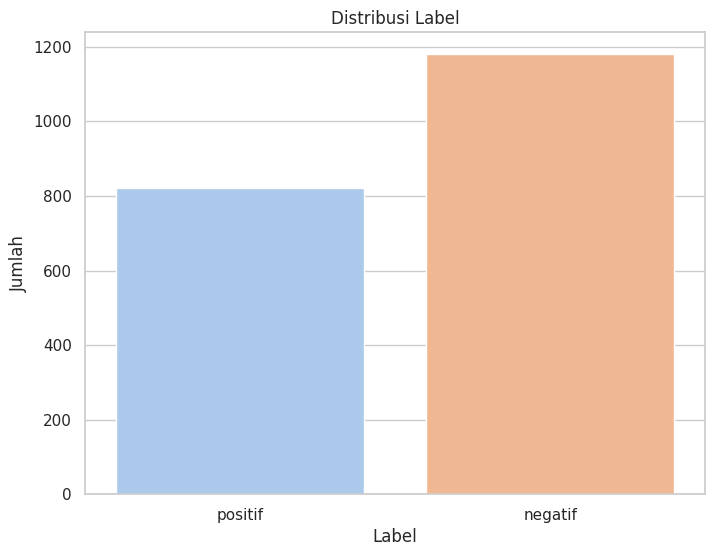

In [ ]:
# Visualisasi distribusi label
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='pastel')
plt.title('Distribusi Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

## **Split Data, Train & Test**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PDM/Stemmed Pre-Processing Grab.csv')
df.head()

,Unnamed: 0,score,content,label,cleaned_content,content_stopWord,stemmed_content
0,0,5,"Guah pelanggan GRAB dari pertama ada GRAB,,, d...",positif,guah pelanggan grab dari pertama ada grab dan ...,guah pelanggan grab grab gua udh pakai apk zam...,guah langgan grab grab gua udh pakai apk zaman...
1,1,4,Dapat dibilang saya sangat bergantung pada Gra...,positif,dapat dibilang saya sangat bergantung pada gra...,dibilang bergantung grab pesan makanan nitip b...,bilang gantung grab pesan makan nitip beli oba...
2,2,3,Titik suka tidak sesuai padahal sudah saya ses...,negatif,titik suka tidak sesuai padahal sudah saya ses...,titik suka sesuai sesuaikan titik biru terkada...,titik suka sesuai sesuai titik biru terkadang ...
3,3,5,Aplikasinya bagus dan tampilan antarmukanya ju...,positif,aplikasinya bagus dan tampilan antarmukanya ju...,aplikasinya bagus tampilan antarmukanya bagus ...,aplikasi bagus tampil antarmuka bagus kendala ...
4,4,5,Driver ojek online merupakan bagian integral d...,positif,driver ojek online merupakan bagian integral d...,driver ojek online integral layanan transporta...,driver ojek online integral layan transportasi...


In [ ]:
x = df['stemmed_content']
y = df['label']
x_train, x_test, y_train, y_test = train_test_split
 (x, y, test_size=0.20, random_state=42)

<ipython-input-11-b858b6d6c6bb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dataset', data=df_plot, palette='pastel')


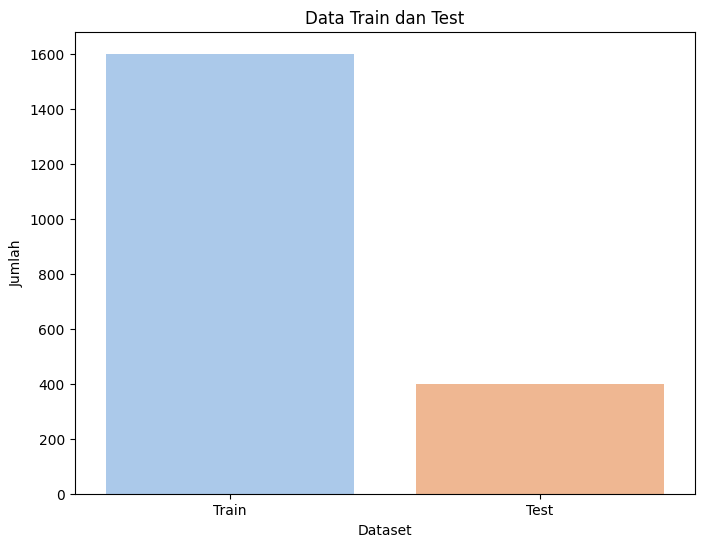

In [ ]:
df_plot = pd.DataFrame({
    'text': list(x_train) + list(x_test),
    'dataset': ['Train'] * len(x_train) + ['Test'] * len(x_test)
})

# Plotting
plt.figure(figsize=(8, 6))
sns.countplot(x='dataset', data=df_plot, palette='pastel')
plt.title('Data Train dan Test')
plt.xlabel('Dataset')
plt.ylabel('Jumlah')
plt.show()

## **Resampling Data**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
# Install TensorFlow versi 2.17.0
!pip install tensorflow==2.17.0
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1600,)
(1600,)
(400,)
(400,)


<ipython-input-31-c63f0419f919>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data_resampled.index, y=data_resampled.values, palette='pastel')


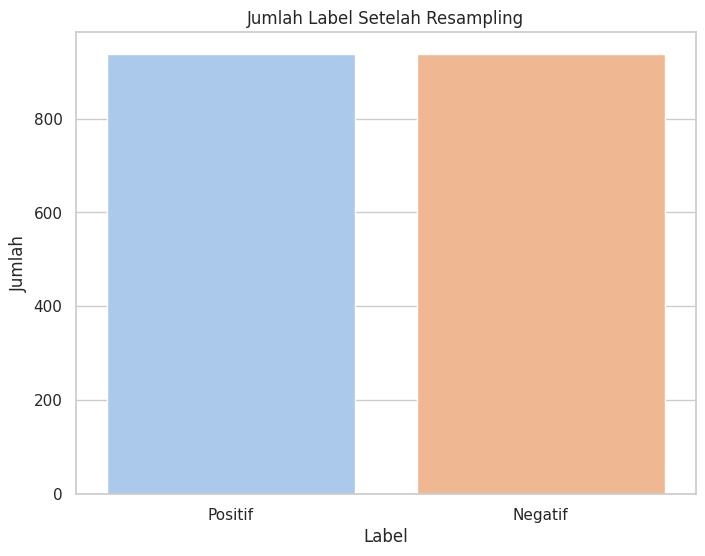

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data resampling
data_resampled = pd.Series({1: 937, 0: 937}, name='count')

# Mengatur gaya dan warna plot menggunakan Seaborn
sns.set(style="whitegrid")

# Membuat figure dan axis
plt.figure(figsize=(8, 6))

# Membuat bar plot dengan Seaborn
ax = sns.barplot(x=data_resampled.index, y=data_resampled.values, palette='pastel')

# Menambahkan label dan judul
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Jumlah Label Setelah Resampling')

# Mengatur label x-ticks
ax.set_xticks(data_resampled.index)
ax.set_xticklabels(['Negatif', 'Positif'])  # Mengganti label angka dengan teks jika perlu

# Menampilkan plot
plt.show()

In [ ]:
from joblib import dump, load

# Simpan vectorizer
dump(tokenizer, 'tokenizer.joblib')

['tokenizer.joblib']

In [ ]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

## **Modeling LSTM**

In [ ]:
# Tokenisasi dan padding
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

# Memastikan tipe data yang benar
x_train_pad = x_train_pad.astype(np.float32)
x_test_pad = x_test_pad.astype(np.float32)

# Memastikan label dalam bentuk numerik
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Menggunakan SMOTE untuk menyeimbangkan data
smote = SMOTE(random_state=40)
x_train_resampled, y_train_resampled = smote.fit_resample
 (x_train_pad, y_train)

print("Jumlah label setelah resampling:")
print(pd.Series(y_train_resampled).value_counts())

# Resampling data
data_resampled = pd.Series(y_train_resampled).value_counts()

# Membangun model LSTM
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim,
                    input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

# Menyimpan tokenizer ke dalam file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

Jumlah label setelah resampling:
1    937
0    937
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Melatih model
history = model.fit(
    x_train_pad,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_test_pad, y_test)
)

# Mengevaluasi model
loss, accuracy = model.evaluate(x_test_pad, y_test)
print(f'Loss Uji: {loss}')
print(f'Akurasi Uji: {accuracy}')

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 293ms/step - accuracy: 0.7180 - loss: 0.6120 - val_accuracy: 0.7900 - val_loss: 0.4827
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.8091 - loss: 0.4341 - val_accuracy: 0.8425 - val_loss: 0.4075
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 331ms/step - accuracy: 0.9292 - loss: 0.2082 - val_accuracy: 0.8275 - val_loss: 0.4890
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 495ms/step - accuracy: 0.9629 - loss: 0.1092 - val_accuracy: 0.8175 - val_loss: 0.5385
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 260ms/step - accuracy: 0.9885 - loss: 0.0599 - val_accuracy: 0.8300 - val_loss: 0.7125
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - accuracy: 0.9849 - loss: 0.0375 - val_accuracy: 0.8200 - val_loss: 0.7257
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - accuracy: 0.9923 - loss: 0.0260 - val_accuracy: 0.8200 - val_loss: 0.8403
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 0.9920 - loss: 0.0282 - val_accu

In [ ]:
model.save('sentiment_model.keras', save_format='keras')

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step


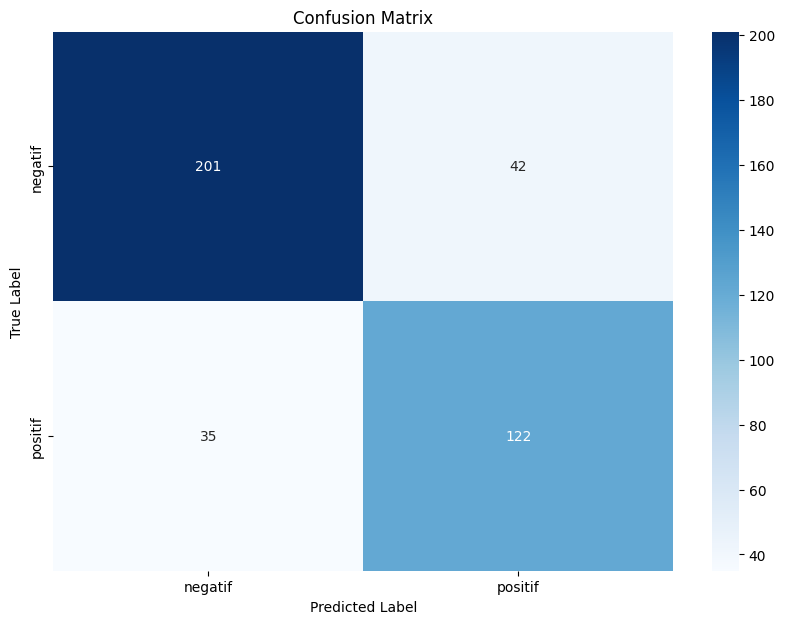

              precision    recall  f1-score   support

     negatif       0.85      0.83      0.84       243
     positif       0.74      0.78      0.76       157

    accuracy                           0.81       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.81      0.81      0.81       400



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Memprediksi label untuk set uji
y_test_pred = model.predict(x_test_pad)
y_test_pred_classes = np.round(y_test_pred).astype(int).reshape(-1)

# Menghasilkan matriks kebingungan
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

# Membuat plot matriks kebingungan
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Label Prediksi')
plt.ylabel('Label Asli')
plt.title('Matriks Kebingungan')
plt.show()

# Mencetak laporan klasifikasi
print(classification_report(y_test, y_test_pred_classes,
                            target_names=le.classes_))


In [ ]:
def preprocess_text(text, tokenizer, max_len):
    # Tokenisasi teks
    seq = tokenizer.texts_to_sequences([text])
    # Padding urutan
    pad_seq = pad_sequences(seq, maxlen=max_len)
    return pad_seq

def predict_sentiment(text, model, tokenizer, max_len):
    # Pra-pemrosesan teks
    processed_text = preprocess_text(text, tokenizer, max_len)
    # Prediksi sentimen
    prediction = model.predict(processed_text)
    # Kembalikan prediksi sebagai positif atau negatif
    return 'Positif' if prediction[0][0] > 0.5 else 'Negatif'

## **TESTING**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


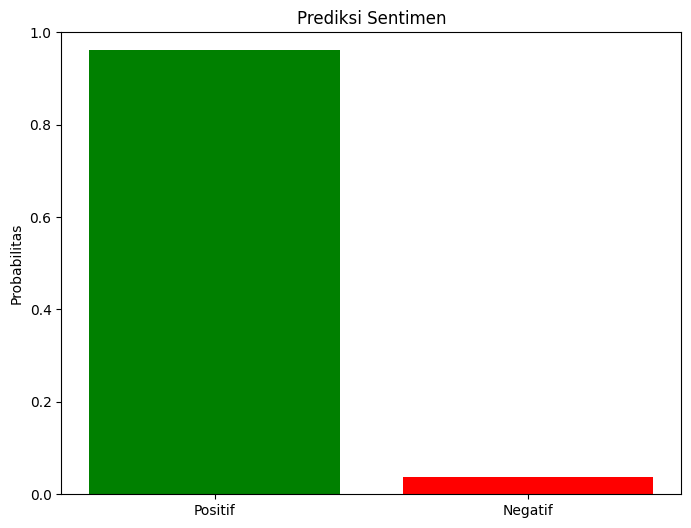

Hasil analisis sentimen dari teks "Pelayanan sangat baik": Positif


In [ ]:
# Input text
input_text = "Pelayanan sangat baik"

# Predict sentiment
sentiment = predict_sentiment(input_text, model, tokenizer, max_len)

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], [model.predict(preprocess_text(input_text, tokenizer, max_len))[0][0], 1 - model.predict(preprocess_text(input_text, tokenizer, max_len))[0][0]], color=['green', 'red'])
plt.title('Prediksi Sentimen')
plt.ylabel('Probabilitas')
plt.ylim([0, 1])
plt.show()

print(f'Hasil analisis sentimen dari teks "{input_text}": {sentiment}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


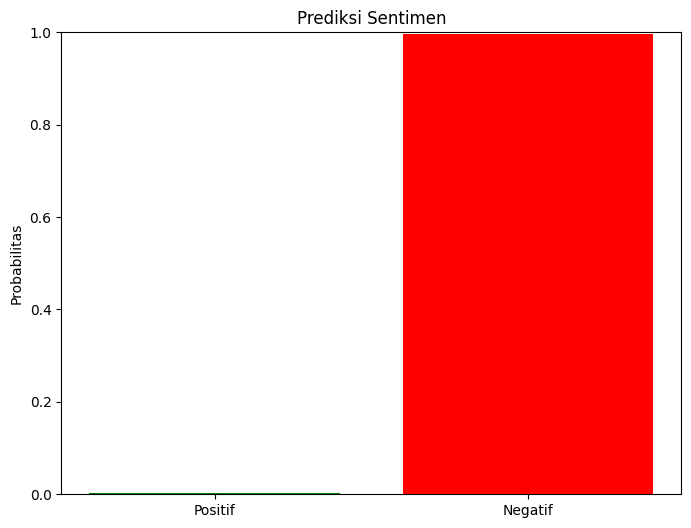

Hasil analisis sentimen dari teks "Pelayanan Jelek Buruk": Negatif


In [ ]:
# Input text
input_text = "Pelayanan Jelek Buruk"

# Predict sentiment
sentiment = predict_sentiment(input_text, model, tokenizer, max_len)

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['Positif', 'Negatif'], [model.predict(preprocess_text(input_text, tokenizer, max_len))[0][0], 1 - model.predict(preprocess_text(input_text, tokenizer, max_len))[0][0]], color=['green', 'red'])
plt.title('Prediksi Sentimen')
plt.ylabel('Probabilitas')
plt.ylim([0, 1])
plt.show()

print(f'Hasil analisis sentimen dari teks "{input_text}": {sentiment}')

In [ ]:
model.save('lstm.h5')

In [ ]:
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
model.save('Lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
